In [1]:
%matplotlib inline

In [2]:
import csv
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from python import IMC, dirtyIMC, Utils
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import linalg as la
import matplotlib.pyplot as plt

In [3]:
data_dir = os.path.abspath(os.path.join('../', 'dataset/'))
ml_dir = os.path.join(data_dir, 'movie_lens/ml-20m/')

In [4]:
M = 27278
U = 138493
T = 1128
ratio = .01
M = int(M*ratio)
U = int(U*ratio)

Genres = ['Action',
'Adventure',
'Animation',
'Children',
'Comedy',
'Crime',
'Documentary',
'Drama',
'Fantasy',
'Film-Noir',
'Horror',
'Musical',
'Mystery',
'Romance',
'Sci-Fi',
'Thriller',
'War',
'Western',
'IMAX']

In [5]:
genome_scores_f = open(ml_dir + 'genome-scores.csv', 'rb')
ratings_f = open(ml_dir + 'ratings.csv', 'rb')
movies_f = open(ml_dir + 'movies.csv', 'rb')
tags_f = open(ml_dir + 'tags.csv', 'rb')

genome_scores_r = csv.reader(genome_scores_f, delimiter=',', quotechar='|')
ratings_r = csv.reader(ratings_f, delimiter=',', quotechar='|')
movies_r = csv.reader(movies_f, delimiter=',', quotechar='|')
tags_r = csv.reader(tags_f, delimiter=',', quotechar='|')

In [6]:
genome_scores_r.next()
GS = np.zeros((M, T))
for row in genome_scores_r:
    if int(row[0]) >= M+1:
        break
    GS[int(row[0])-1, int(row[1])-1] = float(row[2])
    
ratings_r.next()
R = np.zeros((U, M))
Entries = []
for row in ratings_r:
    if int(row[0]) == U+1:
        break
    if int(row[1]) >= M+1:
        continue
    R[int(row[0])-1, int(row[1])-1] = float(row[2])
    Entries.append([int(row[0])-1, int(row[1])-1])

In [7]:
movies_r.next()
MG = np.zeros((M, len(Genres)))
for row in movies_r:
    if int(row[0]) >= M+1:
        break
    gs = row[-1].split('|')
    for g in gs:
        pos = Genres.index(g)
        MG[int(row[0])-1, pos] = 1.0

In [8]:
def prepare_train_test(R, Entries, test_ratio=0.2):
    m = int(len(Entries)*test_ratio)
    n1, n2 = R.shape
    Omega = np.random.choice(len(Entries), m, replace=False)
    mask = np.zeros(R.shape)
    for ij in range(m):
        [i, j] = Entries[Omega[ij]]
        mask[i, j] = 1.0

    R_train = R * mask
    return R_train

def prepare_normal_train_test(R, Entries, test_ratio=0.2):
    d = np.ones(R.shape) * 2.75 * np.float32(R!=0)
    R_norm = R - d
    m = int(len(Entries)*test_ratio)
    n1, n2 = R.shape
    Omega = np.random.choice(len(Entries), m, replace=False)
    mask = np.zeros(R_norm.shape)
    for ij in range(m):
        [i, j] = Entries[Omega[ij]]
        mask[i, j] = 1.0

    R_train = R_norm * mask
    return R_train, R_norm

In [ ]:
"""
Strategy 1: 
X = I
"""
def do_test_imc(k=10, tr=0.2):
    seed = 1
    lamb = 1e-3
    maxiter = 50
    d1 = U
    d2 = len(Genres)
    print 'Generating data...'
    R_train, R_norm = prepare_normal_train_test(R, Entries, test_ratio=0.2)
    X = np.eye(d1)
    Y = MG
    X = np.concatenate((X, np.ones((d1,1))), axis=1)
    Y = np.concatenate((Y, np.ones((M ,1))), axis=1)
    W0 = np.random.randn(d1+1, k)
    H0 = np.random.randn(d2+1, k)

    # Run IMC
    W, H, losses = IMC.IMC(R_train, X, Y, k, lamb, maxiter, W0, H0)

    predict = X.dot(W.T).dot(H).dot(Y.T)
    
    rms = sqrt(mean_squared_error(R_norm[R_norm!=0], predict[R_norm!=0]))
    print 'RMSE: %g' % (rms)
    # relerr = norm(W.T.dot(H) - Z, 'fro')**2 / norm(Z, 'fro')**2 * 100
    relerr = la.norm(predict*np.int32(R_norm!=0) - R_norm, 'fro') ** 2 / la.norm(R_norm, 'fro') ** 2 * 100
    print 'IMC RelErr = %g' % (relerr)
    plt.plot(losses)
    plt.yscale('log')
    plt.show()

    return predict*np.int32(R!=0), R_train

In [ ]:
predict, R_train = do_test_imc()
print predict[predict!=0]
print R[R!=0]
print R_train[R!=0]

In [9]:
def generate_X():
    X = np.zeros((U, len(Genres)))
    c = np.zeros(len(Genres))
    for i in xrange(U):
        for j in xrange(M):
            for k in xrange(len(Genres)):
                if MG[j, k] > 0:
                    X[i, k] = (X[i, k] * c[k] + R[i, j]) / (c[k] + 1)
                    c[k] = c[k] + 1
        c = np.zeros(len(Genres))
    return X

User_side = generate_X()
print User_side.shape

(1384, 19)


In [10]:
"""
Strategy 2: 
X = Ave Rating
"""
def do_test_imc(k=20, tr=0.2):
    seed = 1
    lamb = 1e1
    maxiter = 50
    d1 = U
    d2 = len(Genres)
    print 'Generating data...'
    R_train, R_norm = prepare_normal_train_test(R, Entries, test_ratio=0.2)
    X = User_side
    d = np.ones(X.shape) * 2.75 * np.float32(X!=0)
    X = X - d
    Y = MG
    X = np.concatenate((X, np.ones((d1,1))), axis=1)
    Y = np.concatenate((Y, np.ones((M ,1))), axis=1)
    W0 = np.random.randn(len(Genres)+1, k)
    H0 = np.random.randn(d2+1, k)

    # Run IMC
    W, H, losses = IMC.IMC(R_train, X, Y, k, lamb, maxiter, W0, H0)

    predict = X.dot(W.T).dot(H).dot(Y.T)
    
    rms = sqrt(mean_squared_error(R_norm[R_norm!=0], predict[R_norm!=0]))
    print 'RMSE: %g' % (rms)
    # relerr = norm(W.T.dot(H) - Z, 'fro')**2 / norm(Z, 'fro')**2 * 100
    relerr = la.norm(predict * np.int32(R_norm!=0) - R_norm, 'fro') ** 2 / la.norm(R_norm, 'fro') ** 2 * 100
    print 'IMC RelErr = %g' % (relerr)
    plt.plot(losses)
    plt.yscale('log')
    plt.show()

    return predict*np.int32(R!=0), R_train

Generating data...
Iter 0. Updating W.  Iter 1. Updating W.  RMSE: 2.55619
IMC RelErr = 389.271


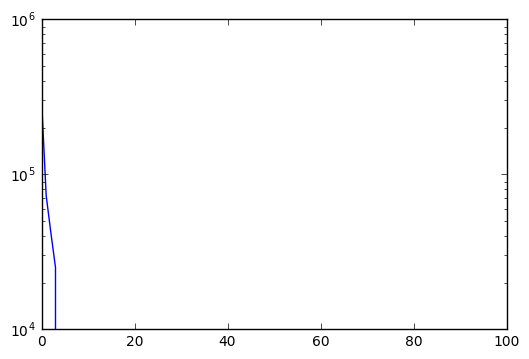

[ 1.27288762  3.22391387  2.50534862 ...,  3.66475859  2.69476676
  6.01425698]
[ 3.5  3.5  3.5 ...,  4.   4.   5. ]
[ 0.    0.75  0.   ...,  0.    0.    0.  ]


In [11]:
predict, R_train = do_test_imc()
print predict[predict!=0]
print R[R!=0]
print R_train[R!=0]

In [14]:
"""
Strategy 2: 
X = Ave Rating
"""
def do_test_dirty_imc(k=20, tr=0.2):
    k1 = k
    k2 = k
    seed = 1
    lamb1 = 1e-3
    lamb2 = 1e1
    maxiter = 50
    d1 = U
    d2 = len(Genres)
    print 'Generating data...'
    R_train, R_norm = prepare_normal_train_test(R, Entries, test_ratio=0.2)
    X = User_side
    d = np.ones(X.shape) * 2.75 * np.float32(X!=0)
    X = X - d
    Y = MG
    X = np.concatenate((X, np.ones((d1,1))), axis=1)
    Y = np.concatenate((Y, np.ones((M ,1))), axis=1)
    W0 = np.random.randn(len(Genres)+1, k1)
    H0 = np.random.randn(d2+1, k1)
    U0 = np.random.randn(U, k2)
    V0 = np.random.randn(M, k2)

    # Run dirtyIMC
    W, H, U_m, V, losses = dirtyIMC.dirtyIMC(R_train, X, Y, k1, k2, lamb1, lamb2, maxiter, W0, H0, U0, V0)
    predict = X.dot(W.T).dot(H).dot(Y.T) + U_m.T.dot(V)
    
    rms = sqrt(mean_squared_error(R_norm[R_norm!=0], predict[R_norm!=0]))
    print 'RMSE: %g' % (rms)
    # relerr = norm(W.T.dot(H) - Z, 'fro')**2 / norm(Z, 'fro')**2 * 100
    relerr = la.norm(predict * np.int32(R_norm!=0) - R_norm, 'fro') ** 2 / la.norm(R_norm, 'fro') ** 2 * 100
    print 'IMC RelErr = %g' % (relerr)
    plt.plot(losses)
    plt.yscale('log')
    plt.show()

    return predict*np.int32(R!=0), R_train

Generating data...
Iter 0. Updating W.  Iter 1. Updating W.  Iter 2. Updating W.  Iter 3. Updating W.  Iter 4. Updating W.  Iter 5. Updating W.  Iter 6. Updating W.  Iter 7. Updating W.  Iter 8. Updating W.  Iter 9. Updating W.  Iter 10. Updating W.  Iter 11. Updating W.  Iter 12. Updating W.  Iter 13. Updating W.  Iter 14. Updating W.  Iter 15. Updating W.  Iter 16. Updating W.  Iter 17. Updating W.  Iter 18. Updating W.  Iter 19. Updating W.  Iter 20. Updating W.  Iter 21. Updating W.  Iter 22. Updating W.  Iter 23. Updating W.  Iter 24. Updating W.  Iter 25. Updating W.  Iter 26. Updating W.  Iter 27. Updating W.  Iter 28. Updating W.  Iter 29. Updating W.  Iter 30. Updating W.  Iter 31. Updating W.  Iter 32. Updating W.  Iter 33. Updating W.  Iter 34. Updating W.  Iter 35. Updating W.  Iter 36. Updating W.  Iter 37. Updating W.  Iter 38. Updating W.  Iter 39. Updating W.  Iter 40. Updating W.  Iter 41. Updating W.  Iter 42. Updating W.  Iter 43. Updating W.  Iter 44. Updating W.  I

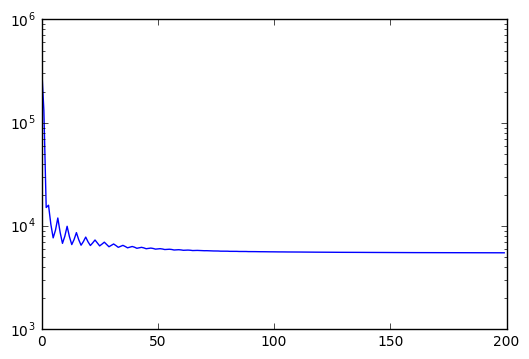

In [15]:
predict, R_train = do_test_dirty_imc()